In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Задача 1

Дана таблица некоторых синтетических данных, на основании которых необходимо выполнить классификацию нового объекта, с помощью метода k-ближайших соседей

In [7]:
df = pd.read_csv('task_3.csv', index_col='id')
X = pd.DataFrame(df.drop(['Class'], axis=1))
y = pd.DataFrame(df['Class'])
point = [52, 87] #координаты из задачи

Найдем для нового объекта трех ближаиших соседей используя евклидову метрику.

In [8]:
neighbor = NearestNeighbors(n_neighbors=3)
neighbor.fit(X)
print(neighbor.kneighbors([point]))

(array([[19.23538406, 25.        , 30.2654919 ]]), array([[6, 4, 9]]))


Ближайший сосед находится на расстоянии 19.23538406, его идентификатор - 7.

Определим класс для нового объекта на основе классов трех ближайших соседей.

In [ ]:
euclid = KNeighborsClassifier(n_neighbors = 3, p = 2)
euclid.fit(X, y)
euclid.predict([point])

array([0])

Найдем для нового объекта трех ближаиших соседей используя метрику городских кварталов (Манхеттенское расстояние).

In [ ]:
man_neighbor = NearestNeighbors(n_neighbors=3, p=1)
man_neighbor.fit(X)
print(man_neighbor.kneighbors([point]))

(array([[25., 26., 34.]]), array([[4, 6, 9]]))


Ближайший сосед находится на расстоянии 25, его идентификатор - 5.

In [ ]:
man = KNeighborsClassifier(n_neighbors = 3, p = 1)
man.fit(X, y)
man.predict([point])

array([0])

На основе классов трех ближайших соседей класс нового объекта - 0.

#Задача 2

Набор данных содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50k в год или нет.

Избавимся от признаков `education`, `marital-status` согласно заданию.

In [ ]:
df = pd.read_csv('/content/adult_data_train.csv')
df = df.drop(['education', 'marital-status'], axis=1)
df.head(3)

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,9,?,Not-in-family,White,Female,0,0,28,United-States,0


In [ ]:
len(df.select_dtypes(exclude='number').columns)

6

Имеем 6 нечисловых признаков.

In [ ]:
df['label'].value_counts()/len(df)

,count
label,
0,0.759175
1,0.240825


Доля объектов класса 0 - 0.759175.

##Построение базовой модели

###Первое приближение

Отберем из набора данных только числовые признаки. Получим обучающую и тестовую выборки при помощи `train_test_split`, используя стратификацию по колонке `label`.

In [ ]:
test_size = 0.2
random_state = 7
stratify = 'label'

X = pd.DataFrame(df[df.select_dtypes(include='number').columns].drop(['label'], axis=1))
y = pd.DataFrame(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                          random_state=random_state,
                                                          stratify=df[stratify])

Вычислим выборочное среднее колонки fnlwgt тренировочного набора данных.

In [ ]:
X_train['fnlwgt'].mean()

189789.851281313

Обучим модель `KNeighborsClassifier()` с параметрами по умолчанию на тренировочных данных. Оценим на тестовых данных при помощи `f1_score()`.

In [ ]:
knn = KNeighborsClassifier().fit(X_train, y_train)
f1_score(y_test, knn.predict(X_test))

0.38031088082901554

Чтобы улучшить показатели модели, нормируем значения признаков, используя `MinMaxScaler()`. Вычислим выборочное среднее колонки `fnlwgt` полученного тренировочного набора данных.

In [ ]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_sc = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)
X_train_sc['fnlwgt'].mean()

0.12055313788274608

Заново обучим и оценим модель на преобразованных данных, вычислив `f1_score()`.

In [ ]:
knn_sc = KNeighborsClassifier().fit(X_train_sc, y_train)
f1_score(y_test, knn_sc.predict(X_test_sc))

0.5160390516039052

Видно, что после линейной нормировки качество выросло.

##Работа с нечисловыми признаками

###Визуализация

Вернем в рассмотрение нечисловые признаки (кроме `education` и `marital-status`). Построим гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку.

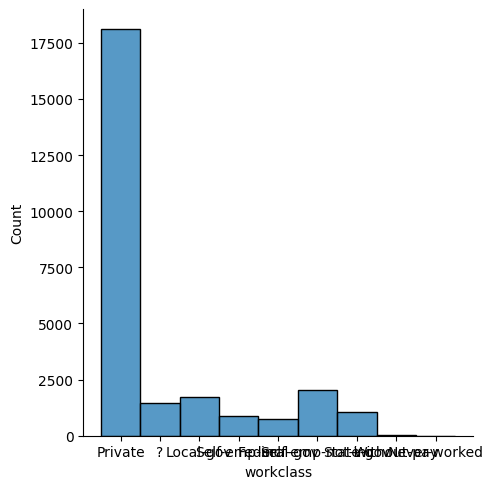

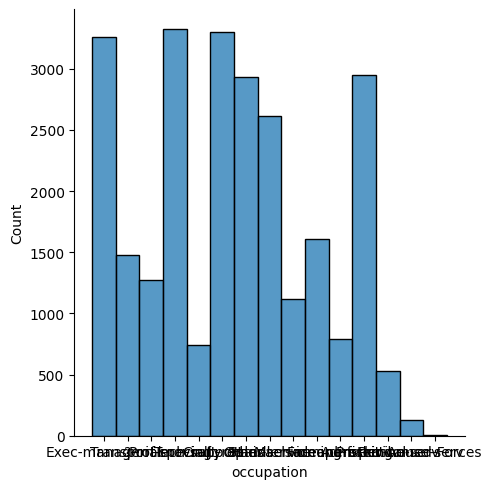

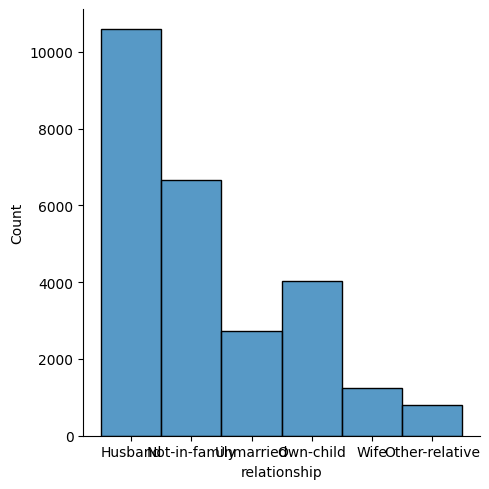

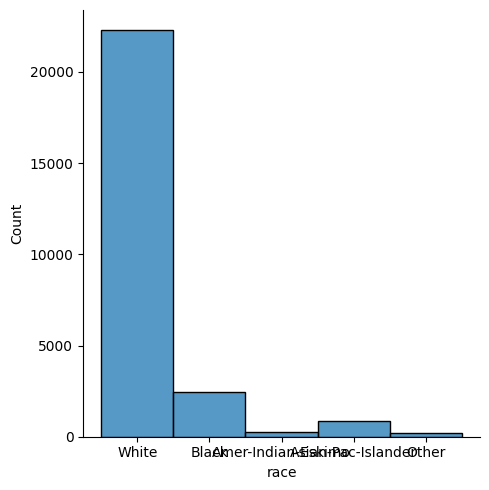

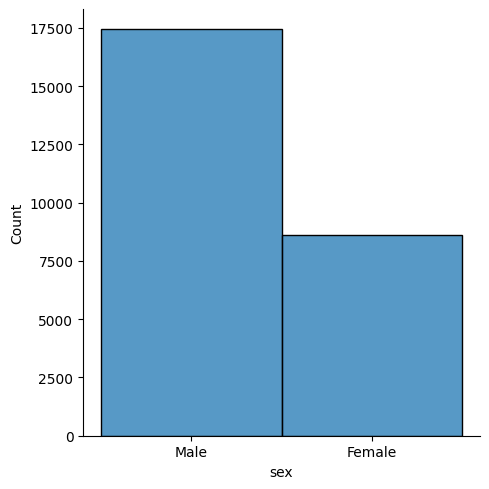

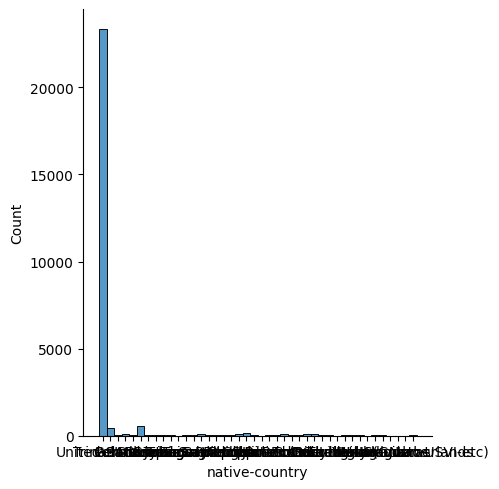

In [ ]:
for col in df.select_dtypes(exclude='number').columns:
  sns.displot(df[col])

###Удаление пропущенных значений

In [ ]:
df = df.replace("?", np.nan)
df.isnull().any(axis=1).sum()

1914

В 1914 строк набора данных присутствует хотя бы одно пропущенное значение.

Удалим строки, содеражащие пропуски. Произведем one-hot кодировние нечисловых признаков с помощью `pd.get_dummies(drop_first=True)`.

In [ ]:
df_one_hot_encoded = df.select_dtypes(exclude='number').dropna()
df_one_hot_encoded = pd.get_dummies(df_one_hot_encoded, drop_first=True)
df_one_hot_encoded = pd.concat([df.select_dtypes(include='number'), df_one_hot_encoded], axis=1)
len(df_one_hot_encoded.columns)

76

Используя полученный набор данных, обучим модель классификации. Произведем предсказания для тестовых данных. Вычислите `f1_score()` модели.

In [ ]:
X = pd.DataFrame(df_one_hot_encoded.drop(['label'], axis=1))
y = pd.DataFrame(df_one_hot_encoded['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                          random_state=random_state,
                                                          stratify=df[stratify])

sc.fit(X_train)
X_train_sc = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

knn_sc = KNeighborsClassifier().fit(X_train_sc, y_train)
f1_score(y_test, knn_sc.predict(X_test_sc))

0.6206896551724138

Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

###Заполнение пропущенных значений

Заполним пропуски самым часто встречающимся значением в рамках столбца. Выполним предобработку данных и обучим модель.

In [ ]:
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])
df_one_hot_encoded = pd.get_dummies(df, drop_first=True)
X = pd.DataFrame(df_one_hot_encoded.drop(['label'], axis=1))
y = pd.DataFrame(df_one_hot_encoded['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                          random_state=random_state,
                                                          stratify=df[stratify])

sc.fit(X_train)
X_train_sc = pd.DataFrame(sc.transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

knn_sc = KNeighborsClassifier().fit(X_train_sc, y_train)
f1_score(y_test, knn_sc.predict(X_test_sc))

0.6098692534795445